### Download german spacy pipeline

In [1]:
!python -m spacy download de_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 9.6 MB/s eta 0:00:0000:0100:02
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import spacy
import re
import umap
nlp = spacy.load('de_core_news_lg')

/Users/jannis/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("/Users/jannis/ASUD_Cyberbullying/prepared_dataframe.csv")

In [4]:
df.head()

,tweet,binaereKlassifikation,granulareKlassifikation,Wörter in Tweet,Wörter pro Tweet,Tweets ohne Satzzeichen,Wortlänge,Durchschnittliche Wortlänge,Verlinkungen,Verlinkung pro Tweet,Hashtags,Hashtags pro Tweet,utf Codes,utf Codes pro Tweet,Emojis,Emojis pro Tweet
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT,"['komisch', 'das', 'die', 'realitätsverweigeru...",11,"['Komisch', 'das', 'die', 'Realitätsverweigeru...","[7, 3, 3, 21, 5, 3, 6, 12, 9, 8, 7]",7.64,"['@JanZimmHHB', '@mopo']",2,[],0,[],0,[],0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE,"['cdu', 'steht', 'seid', 'strauss,', 'kohl,', ...",13,"['CDU', 'steht', 'seid', 'Strauss', 'Kohl', 'S...","[3, 5, 4, 7, 4, 8, 7, 3, 10, 11, 3, 4, 7]",5.85,"['@faznet', '@Gruene_Europa', '@SPDEuropa', '@...",4,[],0,[],0,[],0
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER,"['die', 'gesichter,', 'namen,', 'religion', 'd...",10,"['Die', 'Gesichter', 'Namen', 'Religion', 'der...","[3, 9, 5, 8, 3, 5, 5, 3, 10, 9]",6.00,['@DLFNachrichten'],1,[],0,[],0,[],0
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE,"['wie', 'verwirrt', 'muss', 'man', 'sein', 'um...",28,"['Wie', 'verwirrt', 'muss', 'man', 'sein', 'um...","[3, 8, 4, 3, 4, 2, 4, 2, 7, 3, 9, 12, 3, 6, 4,...",5.43,['@welt'],1,[],0,[],0,[],0
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE,"['weil', 'die', 'afd', 'den', 'ferkelfunk', 'a...",30,"['Weil', 'die', 'AfD', 'den', 'Ferkelfunk', 'a...","[4, 3, 3, 3, 10, 10, 4, 7, 5, 3, 6, 6, 11, 5, ...",5.17,"['@hacker_1991', '@torben_braga']",2,[],0,[],0,[],0


In [5]:
df.granulareKlassifikation.value_counts()

OTHER        2061
INSULT        459
ABUSE         400
PROFANITY     111
Name: granulareKlassifikation, dtype: int64

## Wordclouds for every Category

In [7]:
# words in tweet as one string 
data = df
data["tweets_clean"] = [" ".join(eval(word)) for word in data["Wörter in Tweet"]] 

# drop unicode emojis and LBR
new_tweet_ls = []
for tweet in data.tweets_clean:
    tweet_sp = tweet.split()
    for word in tweet_sp:
        if any(x in word for x in ["000", "LBR", "lbr"]) :
            tweet = tweet.replace(word, "")
        
    new_tweet_ls.append(tweet)

data["tweets_clean"] = new_tweet_ls



In [9]:
# preprocess the tweets
def process_tweets(tweet : str):
    # all lowercase
    tweet = tweet.lower()
    # remove Sonderzeichen etc (based on Sonderzeichen.txt)
    tweet = re.sub('[^a-zA-ZäöüÄÖÜß]', " ", tweet)
    return tweet

In [10]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()


In [11]:
data_pre = data_train
data_pre["tweets_clean"] = [process_tweets(tweet) for tweet in data_pre["tweet"]]

In [12]:
data_pre.head()

,index,tweet,binaereKlassifikation,granulareKlassifikation,Wörter in Tweet,Wörter pro Tweet,Tweets ohne Satzzeichen,Wortlänge,Durchschnittliche Wortlänge,Verlinkungen,Verlinkung pro Tweet,Hashtags,Hashtags pro Tweet,utf Codes,utf Codes pro Tweet,Emojis,Emojis pro Tweet,tweets_clean
0,6,@StZ_NEWS Aber bei läppischen 130.000 Euro der...,OTHER,OTHER,"['aber', 'bei', 'läppischen', '130.000', 'euro...",13,"['Aber', 'bei', 'läppischen', '130000', 'Euro'...","[4, 3, 10, 6, 4, 3, 3, 3, 4, 19, 6, 12, 3]",6.15,['@StZ_NEWS'],1,[],0,[],0,[],0,stz news aber bei läppischen euro der...
1,757,@EleFand @haiderbekah @Eisbert1887 Fand eklige...,OFFENSE,INSULT,"['fand', 'ekliger', 'body', 'shamer', 'schäm',...",6,"['Fand', 'ekliger', 'body', 'shamer', 'schäm',...","[4, 7, 4, 6, 5, 4]",5.00,"['@EleFand', '@haiderbekah', '@Eisbert1887']",3,[],0,[],0,[],0,elefand haiderbekah eisbert fand eklige...
2,99,@Rabid_Glow Diese ganze Umwelt scheiße mann ka...,OFFENSE,INSULT,"['diese', 'ganze', 'umwelt', 'scheiße', 'mann'...",43,"['Diese', 'ganze', 'Umwelt', 'scheiße', 'mann'...","[5, 5, 6, 7, 4, 4, 2, 5, 4, 5, 3, 4, 5, 6, 5, ...",5.19,['@Rabid_Glow'],1,[],0,[],0,[],0,rabid glow diese ganze umwelt scheiße mann ka...
3,2758,"@ToteSeele82 Hm, lange* nicht mehr gehört wird...",OTHER,OTHER,"['hm,', 'lange*', 'nicht', 'mehr', 'gehört', '...",11,"['Hm', 'lange', 'nicht', 'mehr', 'gehört', 'wi...","[2, 5, 5, 4, 6, 4, 6, 3, 4, 3, 7]",4.45,['@ToteSeele82'],1,[],0,[],0,[],0,toteseele hm lange nicht mehr gehört wird...
4,1780,Abschiebung krimineller Migranten nicht möglic...,OFFENSE,ABUSE,"['abschiebung', 'krimineller', 'migranten', 'n...",37,"['Abschiebung', 'krimineller', 'Migranten', 'n...","[11, 11, 9, 5, 7, 4, 5, 2, 5, 6, 9, 6, 5, 3, 5...",6.27,[],0,[],0,[],0,[],0,abschiebung krimineller migranten nicht möglic...


In [13]:
# create spacy docs with a nlp pipeline
# https://spacy.io/usage/processing-pipelines
tweet_docs = [nlp(tweet) for tweet in data_pre["tweets_clean"]]

In [14]:
tweet_docs

[ stz news aber bei läppischen         euro der afd den welt  demokratieuntergang herbei schreiben    wie süß,
  elefand  haiderbekah  eisbert     fand ekliger body shamer schäm dich,
  rabid glow diese ganze umwelt scheiße mann kann es nicht mehr hören das sind alles grüner sumpf und schwachköpfe die sich von steuergeldern finanzieren es kostet arbeitsplätze die städte sterben aus und dieser unsinn hat noch nahrung von den man darf es nicht mehr aussprechen ,
  toteseele   hm  lange  nicht mehr gehört wird wieder mal zeit   lbr        stunden,
 abschiebung krimineller migranten nicht möglich  weil denen in ihrer heimat eventuell gefahr droht  man setzt lieber die eigene bevölkerung der gefahr aus  opfer eines verbrechens zu werden  bevor man ausländische straftäter abschieben mag   lbr  so geht linker gutmenschen terror ,
 der  faktor mensch  will bananen und geländewagen mit     ps  deshalb funktioniert kommunismus nicht  werft eure marx werke endlich in den müll freunde   u     f   

In [15]:
# extract the generated lemmas for words that are no stopwords and have a length of more than two
# Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced
# form belongs to the language. This reduced form or root word is called a lemma.
tweet_words = [
    [
    word.lemma_ for word in doc if ((not word.is_stop) and (len(word) >= 3))
    ]
    for doc in tweet_docs]

In [16]:
tweet_words

[['Stz',
  '--',
  'läppisch',
  '        ',
  'Euro',
  'Afd',
  'Welt',
  'Demokratieuntergang',
  'herbei',
  'schreiben',
  '   ',
  'süß'],
 ['Elefand',
  'Haiderbekah',
  'eisbert',
  '    ',
  'finden',
  'eklig',
  'Body',
  'Shamer',
  'Schäm'],
 ['Rabid',
  'Glow',
  'Umwelt',
  'Scheiße',
  'Mann',
  'hören',
  'grün',
  'Sumpf',
  'schwachköpfe',
  'steuergeldern',
  'finanzieren',
  'kosten',
  'Arbeitsplatz',
  'Stadt',
  'sterben',
  'Unsinn',
  'nahrung',
  'aussprechen'],
 ['toteseele', 'gehören', 'mal', 'lbr', '       ', 'Stunde'],
 ['Abschiebung',
  'kriminell',
  'Migrant',
  'Heimat',
  'eventuell',
  'Gefahr',
  'drohen',
  'setzen',
  'Bevölkerung',
  'Gefahr',
  'Opfer',
  'Verbrechen',
  'bevor',
  'ausländisch',
  'Straftäter',
  'abschieben',
  'lbr',
  'linker',
  'gutmensch',
  'Terror'],
 ['Faktor',
  'Mensch',
  'Banane',
  'Geländewag',
  '    ',
  'funktionieren',
  'Kommunismus',
  'werft',
  'eur',
  'Marx',
  'Werk',
  'Müll',
  'Freund',
  '    ',
 

In [17]:
# create a word2vec model (gensim)
# https://developpaper.com/gensim-model-parameters-of-word2vec/
# Window: refers to the window size of training. 8 means that the first 8 words and the last 8 words are considered 
word2vec = Word2Vec(tweet_words, min_count=3, sg=1, hs=0, negative=9,
                    ns_exponent=0.69, window=6, vector_size=60, epochs=80)

# train the model
word2vec.train(tweet_words, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

# maybe checkout pretrained word2vec models
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

(1227921, 2290480)

In [18]:
# test word similarities
def test_word_sim(word_a, word_b):
    print(f'{word_a} | {word_b}: {word2vec.wv.similarity(word_a, word_b)}')
    
    
test_word_sim("CDU", "SPD")
test_word_sim("Korruption", "Europa")
test_word_sim("Merkel", "CDU")
test_word_sim("Flüchtling", "Terror")
test_word_sim("Witz", "Karte")
test_word_sim("CDU", "Ferkel")

CDU | SPD: 0.6564212441444397
Korruption | Europa: 0.3408260941505432
Merkel | CDU: 0.454535573720932
Flüchtling | Terror: 0.3709357976913452
Witz | Karte: 0.27697497606277466
CDU | Ferkel: 0.20841357111930847


In [19]:
# test2 word similarities
def test2_word_sim(word_list):
    print(f'{word_list}: {word2vec.wv.most_similar(positive=word_list, negative=[], topn = 5)}')
    
test2_word_sim(["Deutschland", "Merkel"])
test2_word_sim(["Flüchtling", "Deutschland"])
test2_word_sim(["Polizei"])
test2_word_sim(["Feiertag"])

['Deutschland', 'Merkel']: [('Migrationspakt', 0.6723037958145142), ('überall', 0.5954393148422241), ('Flasche', 0.5852060914039612), ('CDU', 0.5788894295692444), ('Kanzlerin', 0.5729695558547974)]
['Flüchtling', 'Deutschland']: [('Kolonist', 0.5927925109863281), ('steigen', 0.5897562503814697), ('Karrenbauer', 0.5681115388870239), ('Armut', 0.5596180558204651), ('loswerden', 0.5534074902534485)]
['Polizei']: [('hambibleiben', 0.647968053817749), ('vorgehen', 0.5508056879043579), ('Aktivist', 0.5483012795448303), ('importiert', 0.5319312810897827), ('sogenannter', 0.509794294834137)]
['Feiertag']: [('Catinchief', 0.7449750304222107), ('fröhlich', 0.7298333048820496), ('Urlaub', 0.6713811755180359), ('gesetzlich', 0.6680327653884888), ('korrekt', 0.6658231019973755)]


In [20]:
test2_word_sim(["Geld"])

test2_word_sim(["Welt"])

['Geld']: [('Gold', 0.566405177116394), ('jenshag', 0.555010199546814), ('Rede', 0.5426620244979858), ('zahlen', 0.5333633422851562), ('verdienen', 0.5259148478507996)]
['Welt']: [('holen', 0.5298749804496765), ('liberale', 0.46344485878944397), ('Abtreibung', 0.460858553647995), ('gesamt', 0.44480741024017334), ('Hintern', 0.4398077726364136)]


In [21]:
# assign a category to every word
category_dict = {}
for word in word2vec.wv.index_to_key:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]])
        max_numb[cat] = count   
    category_dict[word] = max(max_numb, key = max_numb.get)

In [22]:
# assign a category to every word (percentage)
category_dict_per = {}
for word in word2vec.wv.index_to_key:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]]) / len(data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"])
        max_numb[cat] = count   
    category_dict_per[word] = max(max_numb, key = max_numb.get)

In [23]:
len(category_dict)

1913

In [24]:
# check the distribution (count)
from collections import Counter
category_dict
Counter(category_dict.values())


Counter({'OTHER': 1644, 'ABUSE': 125, 'INSULT': 127, 'PROFANITY': 17})

In [25]:
# check the distribution (percentage)
from collections import Counter
category_dict
Counter(category_dict_per.values())

Counter({'OTHER': 886, 'PROFANITY': 205, 'ABUSE': 487, 'INSULT': 335})

In [26]:
data_pre["granulareKlassifikation"].value_counts()

OTHER        1547
INSULT        346
ABUSE         303
PROFANITY      77
Name: granulareKlassifikation, dtype: int64

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


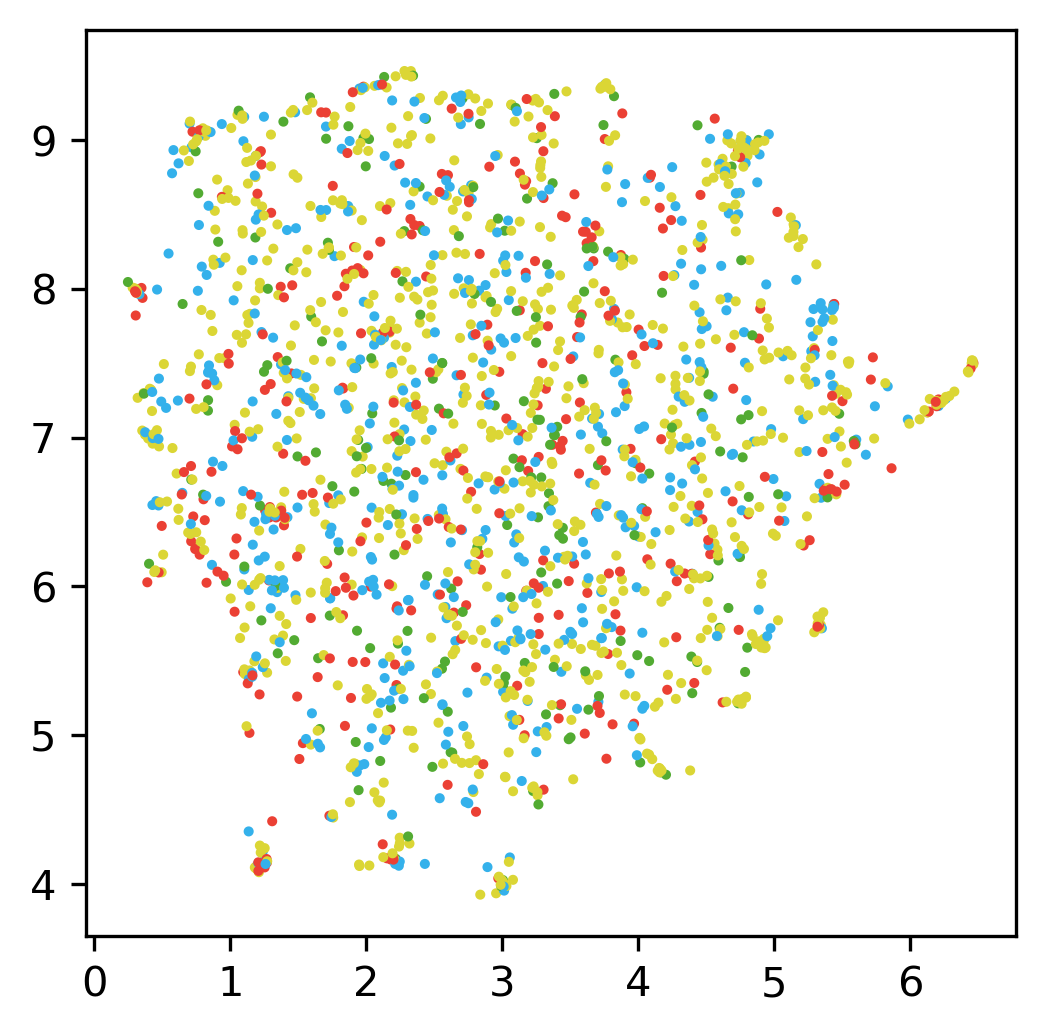

In [27]:
# create a plot of the word vectors
# reduce to two dimensions
reducer = umap.UMAP(metric='cosine', n_components=2, n_neighbors=15, min_dist=0.00, random_state=0)

# X holds the word vectors for all words in vocabulary
X = word2vec.syn1neg

# transform to two dimensions
embedding = reducer.fit_transform(X[:,:])

# plot projected word vectors
plt.figure(figsize=(4,4), dpi=300)

# scatterplot of projected word vectors
colors = {"INSULT": '#eb4034',
          "OTHER": "#dbd635",
          "ABUSE": '#34b1eb',
          "PROFANITY": "#52ab32"}

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [colors.get(cat, " ") for cat in list(category_dict_per.values())[:]],
    s = 2
    )

In [ ]:
X

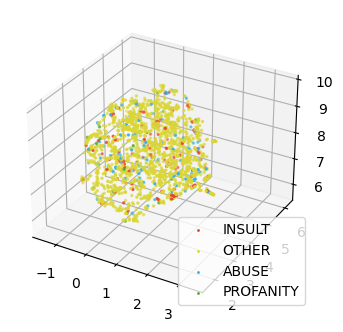

In [28]:
# maybe we should plot this with 3 dimensions 
# Project into 3D space
reducer3D = umap.UMAP(metric='cosine', n_components=3, n_neighbors=15, min_dist=0.00, random_state=0)
embedding3D = reducer3D.fit_transform(X[:,:])


# plot in 3D and create animation (rotate space)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    embedding3D[:, 0],
    embedding3D[:, 1],
    embedding3D[:, 2],
    c = [colors.get(cat, " ") for cat in list(category_dict.values())[:]],
    s = 2
    )
for color in ['#eb4034',"#dbd635",'#34b1eb',"#52ab32"]:
    lbl = list(colors.keys())[list(colors.values()).index(color)]
    plt.scatter([],[], [], color=color, label=lbl)
plt.legend()

def rotate(angle):
    ax.view_init(azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362,10), repeat=True)

## Classify new tweets

In [29]:
# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    # list of words in the word2vec model
    words = [word for word in words if word in word2vec.wv.index_to_key]
    # get the vectors
    vectors = np.array([word2vec.wv.get_vector(word) for word in words])
    # return the sum of all vectors devided by the amount of words from words in the model
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each tweet
tweet_vectors = []
for tweet in tweet_words:
    vec = get_com_vector(tweet)
    tweet_vectors.append(vec)


/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_28915/2279988988.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return vector / len(words)


In [37]:
# Encode the classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["granulareKlassifikation"])
encoder.classes_

array(['ABUSE', 'INSULT', 'OTHER', 'PROFANITY'], dtype=object)

In [55]:
tweet_vectors_arr = np.empty([2, 2])
tweet_vectors_arr = [np.append(tweet_vectors_arr, tweet) for tweet in tweet_vectors]


In [58]:
np.concatenate(tweet_vectors, axis = 0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 92 has 0 dimension(s)

In [45]:
# Train a Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict([new_tweet_vector(x) for x in data_test.tweets_clean])
# rfc_human_readeable = encoder.inverse_transform(rfc_predictions)

/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_28915/1811978246.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rfc.fit(np.array(tweet_vectors), y_transformed)


ValueError: setting an array element with a sequence.

In [30]:
# function to preprocess and transform new tweets
def new_tweet_vector(tweet : str):
    prep_new = process_tweets(tweet)
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_tweet_v = get_com_vector(words_new)

    return new_tweet_v

In [ ]:
len()

In [31]:
# create predictions with test data
# classify_tweet(tweet_vectors, new_tweet_vector(data_test.tweet[757]))
cat_predictions = [classify_tweet(tweet_vectors, new_tweet_vector(x))[0] for x in data_test.tweets_clean]


NameError: name 'classify_tweet' is not defined

In [ ]:
# evaluate predictions
acc = 0
for i in range(len(cat_predictions)):
    if cat_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(cat_predictions)        

In [ ]:
accuracy

In [ ]:
cat_predictions[:10]

In [ ]:
data_test["granulareKlassifikation"][:10]

In [ ]:
# value counts of predictions
[cat_predictions.count(x) for x in ['ABUSE', 'PROFANITY','INSULT', 'OTHER']]

In [ ]:
data_test["granulareKlassifikation"].value_counts()

In [ ]:
data_test.head(10)